In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import osmnx as ox
import geopandas as gpd
import networkx as nx

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
#load in the hospital sites data to be used to score potential viable locations
hospitals = pd.read_csv('/Users/muhammad-faaiz.shanawas/Documents/Live Projects/MCLP/data/cambridge_uni_hospital_sites.csv')
hospitals

,Code,Name,National Grouping,High Level Health Geography,Address Line 1,Address Line 2,Address Line 3,Address Line 4,Address Line 5,Postcode,Open Date,Close Date,Organisation Sub-Type Code,Parent Org Code
0,A6B3B,CUH AT MEADOWS COMMUNITY CENTRE,Y61,QUE,1 ST. CATHARINES ROAD,NaN,NaN,CAMBRIDGE,NaN,CB4 3XJ,20211001,NaN,NaN,RGT
1,A9J5N,CUH AT ROSMINI CENTRE,Y61,QUE,69A QUEENS ROAD,NaN,NaN,WISBECH,NaN,PE13 2PH,20220401,NaN,NaN,RGT
2,B1C9Z,CUH AT SPECSAVERS ROYSTON,Y61,QUE,27A-27B HIGH STREET,NaN,NaN,ROYSTON,NaN,SG8 9AA,20220401,NaN,NaN,RGT
3,B5D1I,CUH AT DODDINGTON HOSPITAL,Y61,QUE,BENWICK ROAD,DODDINGTON,NaN,MARCH,NaN,PE15 0UG,20210401,NaN,NaN,RGT
4,C5Z7J,CAMBRIDGE BIOMEDICAL RESEARCH CENTRE - VALNEVA...,Y61,QUE,HILLS ROAD,NaN,NaN,CAMBRIDGE,NaN,CB2 0QQ,20210401,NaN,NaN,RGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,RGT98,NUFFIELD HEALTH CAMBRIDGE HOSPITAL,Y61,QUE,4 TRUMPINGTON ROAD,NaN,NaN,CAMBRIDGE,CAMBRIDGESHIRE,CB2 8AF,20121001,NaN,NaN,RGT
174,RGT99,ST MARY'S SURGERY,Y61,QUE,37 ST. MARYS STREET,NaN,NaN,ELY,CAMBRIDGESHIRE,CB7 4HF,20121001,NaN,NaN,RGT
175,T4O3M,CUH AT COLCHESTER STARS,Y61,QUE,5A QUEEN STREET,NaN,NaN,COLCHESTER,NaN,CO1 2PG,20210401,NaN,NaN,RGT
176,T8C3T,CUH AT ROYAL PAPWORTH HOSPITAL,Y61,QUE,PAPWORTH ROAD,CAMBRIDGE BIOMEDICAL CAMPUS,NaN,CAMBRIDGE,NaN,CB2 0AY,20201001,NaN,NaN,RGT


/usr/local/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


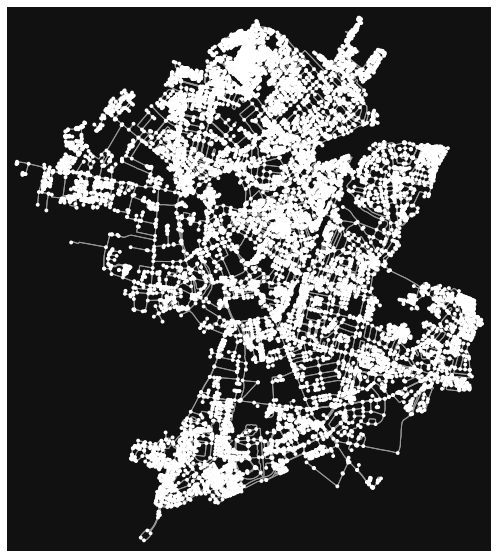

In [4]:

G = ox.graph.graph_from_place('Cambridge', simplify = True, network_type = 'walk')

# The following code can be run to decrease the time required to generate OSMnx network graphs.
# If a node cannot access at least 10% of other nodes it is removed from the network
#---------------------------------------------------------------------------------------

remove_list = []
num_nodes = len(G.nodes)
for node in G.nodes:  
     reach = len(nx.descendants(G, node))
     if reach < num_nodes / 10:
         remove_list.append(node)
for node in remove_list:
     G.remove_node(node)

#---------------------------------------------------------------------------------------
ox.plot_graph(G, figsize = (10,10));

In [6]:
nodes, edges = ox.graph_to_gdfs(G)
nodes

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
104521,52.203550,0.123491,traffic_signals,3,NaN,POINT (0.12349 52.20355)
104522,52.204039,0.123043,NaN,3,NaN,POINT (0.12304 52.20404)
104523,52.205293,0.121804,NaN,3,NaN,POINT (0.12180 52.20529)
104524,52.205374,0.121364,NaN,3,NaN,POINT (0.12136 52.20537)
104525,52.206162,0.120605,NaN,3,NaN,POINT (0.12061 52.20616)
...,...,...,...,...,...,...
10556718656,52.212910,0.141876,NaN,3,NaN,POINT (0.14188 52.21291)
10556718665,52.214972,0.142650,NaN,3,NaN,POINT (0.14265 52.21497)
10556718666,52.215072,0.142450,NaN,1,NaN,POINT (0.14245 52.21507)


In [7]:
#get the target addresses from the hospitals dataframe
target_index1 = 176
target_index2 = 173

target_address1 = hospitals['Address Line 1'][target_index1] + ', Cambridge'
target_address2 = hospitals['Address Line 1'][target_index2] + ', Cambridge'

#convert the addresses to lat long coordinates and get the nearest node on the graph
target_coords1 = ox.geocode(target_address1)
target_node1 = ox.get_nearest_node(G, target_coords1)

target_coords2 = ox.geocode(target_address2)
target_node2 = ox.get_nearest_node(G, target_coords2)

list_of_target_nodes = [target_node1, target_node2]

/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [23]:
#generate the random sample of 100 samples by first removing the target node location from the dataframe
nodes_df = nodes.copy()
nodes_df = nodes_df[~nodes_df.index.isin(list_of_target_nodes)] #get the dataframe of nodes that do not have any target nodes in them
nodes_sample = nodes_df[['y', 'x']].sample(n = 100, random_state = 1234)
nodes_sample

,y,x
osmid,,
21591575,52.224083,0.110663
1488979818,52.198241,0.111453
7707713683,52.173525,0.123178
1547531115,52.233916,0.128835
1543118407,52.234243,0.133058
...,...,...
4772911471,52.172102,0.142838
1646095809,52.189553,0.122449
3268544965,52.213930,0.151471


In [24]:
#creating a function to calculate a score from a list of lengths calculated from the target node to each of the 100 sample nodes
def create_score(list_of_lengths):
    score = 1000
    for l in list_of_lengths:
        deduction = (((l/1000)/4.5)*60) * 5 #get the length in km divide by speed 4.5 km/h then divide by 60 to get time in minutes
        score = score - deduction #decrement the score by the derivation of time taken to each of the 100 nodes
        return score

In [28]:
#define a function to calculate multiple shortest route lengths from the target node to each of the 100 sample nodes
def create_list_of_lengths(nodes_sample, target_node):
    list_of_lengths = []
    for node in nodes_sample.index:
        length = nx.shortest_path_length(G, source=node, target=target_node, weight='length') #calculate route from target node to sample node
        list_of_lengths.append(length) #append the length to the list
    
    return list_of_lengths
    

In [29]:
#run the function defined above to generate a list of lengths between the target nodes and sample nodes
#then generate the score for each and store them in a dictionary
target_scores = {}
target_scores['Site 1'] = create_score(create_list_of_lengths(nodes_sample, list_of_target_nodes[0]))
target_scores['Site 2'] = create_score(create_list_of_lengths(nodes_sample, list_of_target_nodes[1]))
target_scores

{'Site 1': 534.4081333333332, 'Site 2': 703.1283999999999}

In [30]:
#print the scores for each proposed target site
print('The score for Site 1: {} is {}'.format(hospitals['Name'].iloc[target_index1], target_scores['Site 1']))
print('The score for Site 2: {} is {}'.format(hospitals['Name'].iloc[target_index2], target_scores['Site 2']))

The score for Site 1: CUH AT ROYAL PAPWORTH HOSPITAL is 534.4081333333332
The score for Site 2: NUFFIELD HEALTH CAMBRIDGE HOSPITAL is 703.1283999999999


In [31]:
#initiate dictionary to store routes for all 100 nodes for each proposed site
target_to_nodes_routes = {}
target_node_names = ['Site1', 'Site2']

In [35]:
#generate multiple shortest routes for each site and store in dictionary for plotting
for site, target_node in zip(target_node_names, list_of_target_nodes):
    list_of_routes = []
    for node in nodes_sample.index:
        route = nx.shortest_path(G, source=node, target=target_node, weight='length') #calculate route from target node to sample node
        list_of_routes.append(route) #append the length to the list
    target_to_nodes_routes[site] = list_of_routes
    


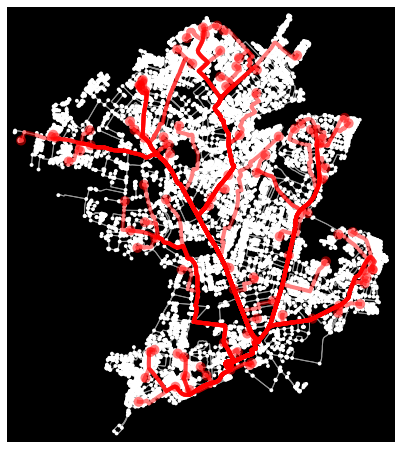

In [36]:
#plot the routes from Site 1 to all 100 sample nodes
fig, ax = ox.plot_graph_routes(G, target_to_nodes_routes['Site1'], route_linewidth=6, bgcolor='k')

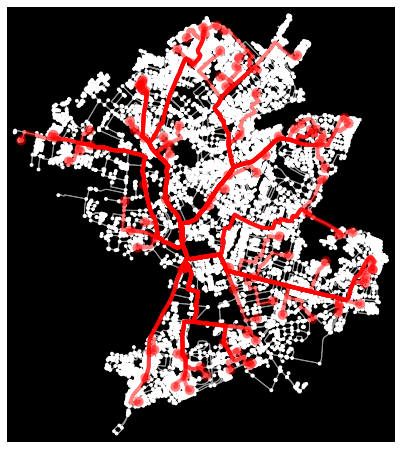

In [37]:
#plot the routes from Site 2 to all 100 sample nodes
fig, ax = ox.plot_graph_routes(G, target_to_nodes_routes['Site2'], route_linewidth=6, bgcolor='k')